# 라이브러리

In [ ]:
! pip3 install koreanize_matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.0 MB/s eta 0:00:00


# 데이터 불러오기

In [ ]:
log_2022_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/log_2022.csv"
log_2022_df = pd.read_csv(log_2022_path)

log_2023_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/log_2023.csv"
log_2023_df = pd.read_csv(log_2023_path)

log_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/log_df.csv"
log_df = pd.read_csv(log_path)

In [ ]:
# 1. UTC 제거
log_2022_df["timestamp_clean"] = log_2022_df["timestamp"].str.replace(" UTC", "", regex=False)

# 2. datetime으로 변환
log_2022_df["timestamp_clean"] = pd.to_datetime(
    log_2022_df["timestamp_clean"],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors="coerce"
)

# 3. NaT가 생긴 경우, 포맷이 다른 문자열을 다시 처리 (마이크로초 없는 경우 등)
mask_failed = log_2022_df["timestamp_clean"].isna()
log_2022_df.loc[mask_failed, "timestamp_clean"] = pd.to_datetime(
    log_2022_df.loc[mask_failed, "timestamp"].str.replace(" UTC", "", regex=False),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# 4. 정리
log_2022_df["timestamp"] = log_2022_df["timestamp_clean"]
log_2022_df.drop(columns="timestamp_clean", inplace=True)

# 쿼리 파라미터 제거
log_2022_df["cleaned_url"] = log_2022_df["URL"].str.split("?").str[0]

# 유저별로 timestamp 순 정렬
log_2022_df = log_2022_df.sort_values(by=['user_uuid', 'timestamp'])

In [ ]:
# 1. UTC 제거
log_2023_df["timestamp_clean"] = log_2023_df["timestamp"].str.replace(" UTC", "", regex=False)

# 2. datetime으로 변환
log_2023_df["timestamp_clean"] = pd.to_datetime(
    log_2023_df["timestamp_clean"],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors="coerce"
)

# 3. NaT가 생긴 경우, 포맷이 다른 문자열을 다시 처리 (마이크로초 없는 경우 등)
mask_failed = log_2023_df["timestamp_clean"].isna()
log_2023_df.loc[mask_failed, "timestamp_clean"] = pd.to_datetime(
    log_2023_df.loc[mask_failed, "timestamp"].str.replace(" UTC", "", regex=False),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# 4. 정리
log_2023_df["timestamp"] = log_2023_df["timestamp_clean"]
log_2023_df.drop(columns="timestamp_clean", inplace=True)

# 쿼리 파라미터 제거
log_2023_df["cleaned_url"] = log_2023_df["URL"].str.split("?").str[0]

# 유저별로 timestamp 순 정렬
log_2023_df = log_2023_df.sort_values(by=['user_uuid', 'timestamp'])

In [ ]:
# 1. UTC 제거
log_df["timestamp_clean"] = log_df["timestamp"].str.replace(" UTC", "", regex=False)

# 2. datetime으로 변환
log_df["timestamp_clean"] = pd.to_datetime(
    log_df["timestamp_clean"],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors="coerce"
)

# 3. NaT가 생긴 경우, 포맷이 다른 문자열을 다시 처리 (마이크로초 없는 경우 등)
mask_failed = log_df["timestamp_clean"].isna()
log_df.loc[mask_failed, "timestamp_clean"] = pd.to_datetime(
    log_df.loc[mask_failed, "timestamp"].str.replace(" UTC", "", regex=False),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# 4. 정리
log_df["timestamp"] = log_df["timestamp_clean"]
log_df.drop(columns="timestamp_clean", inplace=True)

# 쿼리 파라미터 제거
log_df["cleaned_url"] = log_df["URL"].str.split("?").str[0]

# 유저별로 timestamp 순 정렬
log_df = log_df.sort_values(by=['user_uuid', 'timestamp'])

# Acquisition 22 + 23 != 22 23 concat

## concat_done_df 만들기

In [ ]:
cleaned_unique_urls = log_df["cleaned_url"].unique()

acquisition_keywords = [
    "signup",
    "signup/step1",
    "signup/step2",
    "signup/step3",
    "api/signup"
]

# Acquisition URL로 분류
acquisition_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in acquisition_keywords)]

# 가입 관련 URL 방문 로그 추출
concat_acquisition_logs = log_df[log_df["cleaned_url"].isin(acquisition_urls)]

In [ ]:
# clean_url 만들기
concat_acquisition_logs["clean_url"] = concat_acquisition_logs["cleaned_url"].str.lower()

# 퍼널 단계 정의
funnel_stages = {
    "detail": ["detail"],
    "step1": ["signup/step1"],
    "step2": ["signup/step2"],
    "step3": ["signup/step3"]
}

# 퍼널 단계 부여 함수
def assign_funnel_stage(url):
    url = str(url).lower()
    for stage, keywords in funnel_stages.items():
        if any(k in url for k in keywords):
            return stage
    return "other"

# funnel_stage 컬럼 생성
concat_acquisition_logs["funnel_stage"] = concat_acquisition_logs["clean_url"].apply(assign_funnel_stage)

<ipython-input-15-2648b4d89ab4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_acquisition_logs["clean_url"] = concat_acquisition_logs["cleaned_url"].str.lower()
<ipython-input-15-2648b4d89ab4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_acquisition_logs["funnel_stage"] = concat_acquisition_logs["clean_url"].apply(assign_funnel_stage)


In [ ]:
concat_detail_stage = concat_acquisition_logs[concat_acquisition_logs["funnel_stage"] == "detail"]
concat_detail_members = concat_detail_stage["user_uuid"].unique()
concat_detail_numbers = concat_detail_stage["user_uuid"].nunique()

concat_detail_df = concat_acquisition_logs[concat_acquisition_logs['user_uuid'].isin(concat_detail_members)].reset_index(drop=True)

# detail -> step1
concat_step_1_stage = concat_detail_df[concat_detail_df["funnel_stage"] == "step1"]

concat_step_1_members = concat_step_1_stage["user_uuid"].unique()

concat_step_1_stage = concat_detail_df[concat_detail_df["funnel_stage"] == "step1"]
concat_step_1_members = concat_step_1_stage["user_uuid"].unique()
concat_step_1_numbers = concat_step_1_stage["user_uuid"].nunique()

concat_step_1_df = concat_detail_df[concat_detail_df['user_uuid'].isin(concat_step_1_members)].reset_index(drop=True)

# step1 -> step2
concat_step_2_stage = concat_step_1_df[concat_step_1_df["funnel_stage"] == "step2"]
concat_step_2_members = concat_step_2_stage["user_uuid"].unique()
concat_step_2_numbers = concat_step_2_stage["user_uuid"].nunique()

concat_step_2_df = concat_step_1_df[concat_step_1_df['user_uuid'].isin(concat_step_2_members)].reset_index(drop=True)

# step2 -> step3
concat_step_3_stage = concat_step_2_df[concat_step_2_df["funnel_stage"] == "step3"]
concat_step_3_members = concat_step_3_stage["user_uuid"].unique()
concat_step_3_numbers = concat_step_3_stage["user_uuid"].nunique()

concat_step_3_df = concat_step_2_df[concat_step_2_df['user_uuid'].isin(concat_step_3_members)].reset_index(drop=True)
concat_done_df = concat_step_3_df[concat_step_3_df["cleaned_url"] == "signup/step3/done"]
concat_done_numbers = concat_done_df["user_uuid"].nunique()

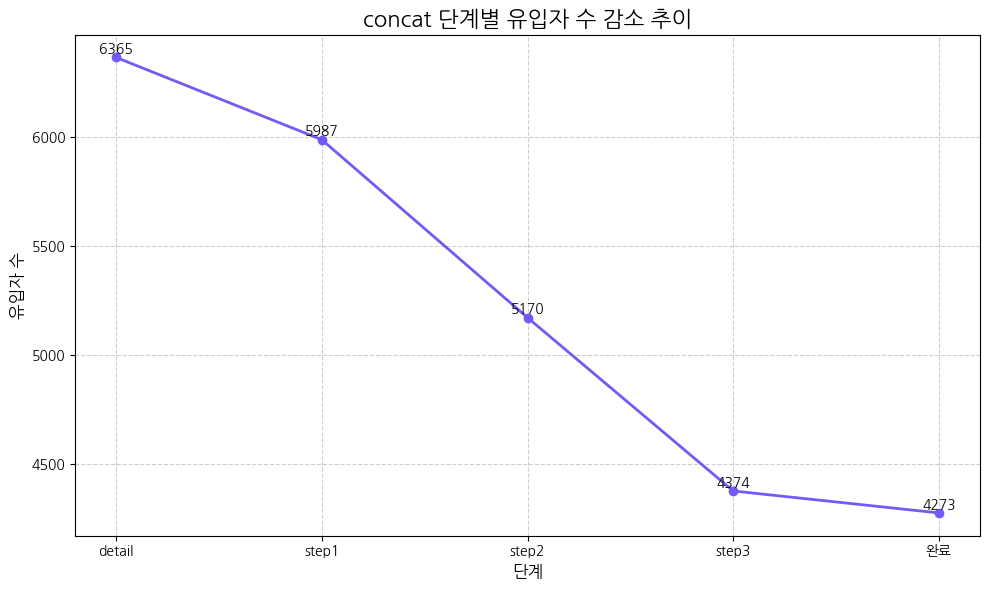

In [ ]:
# 단계 이름과 유입자 수 (너의 실제 값으로 바꿔줘)
stage_names = ["detail", "step1", "step2", "step3", "완료"]
counts = [concat_detail_numbers, concat_step_1_numbers, concat_step_2_numbers, concat_step_3_numbers, concat_done_numbers]

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(stage_names, counts, marker='o', linestyle='-', color='#7459f6', linewidth=2)
plt.title("concat 단계별 유입자 수 감소 추이", fontsize=16)
plt.xlabel("단계", fontsize=12)
plt.ylabel("유입자 수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 각 점에 유입자 수 표시
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## log_2022_done_df 만들기

In [ ]:
# 가입 관련 URL 방문 로그 추출
log_2022_acquisition_logs = log_2022_df[log_2022_df["cleaned_url"].isin(acquisition_urls)]

In [ ]:
# clean_url 만들기
log_2022_acquisition_logs["clean_url"] = log_2022_acquisition_logs["cleaned_url"].str.lower()

# 퍼널 단계 정의
funnel_stages = {
    "detail": ["detail"],
    "step1": ["signup/step1"],
    "step2": ["signup/step2"],
    "step3": ["signup/step3"]
}

# 퍼널 단계 부여 함수
def assign_funnel_stage(url):
    url = str(url).lower()
    for stage, keywords in funnel_stages.items():
        if any(k in url for k in keywords):
            return stage
    return "other"

# funnel_stage 컬럼 생성
log_2022_acquisition_logs["funnel_stage"] = log_2022_acquisition_logs["clean_url"].apply(assign_funnel_stage)

<ipython-input-17-9498941426b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_2022_acquisition_logs["clean_url"] = log_2022_acquisition_logs["cleaned_url"].str.lower()
<ipython-input-17-9498941426b8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_2022_acquisition_logs["funnel_stage"] = log_2022_acquisition_logs["clean_url"].apply(assign_funnel_stage)


In [ ]:
log_2022_detail_stage = log_2022_acquisition_logs[log_2022_acquisition_logs["funnel_stage"] == "detail"]
log_2022_detail_members = log_2022_detail_stage["user_uuid"].unique()
log_2022_detail_numbers = log_2022_detail_stage["user_uuid"].nunique()

log_2022_detail_df = log_2022_acquisition_logs[log_2022_acquisition_logs['user_uuid'].isin(log_2022_detail_members)].reset_index(drop=True)

# detail -> step1
log_2022_step_1_stage = log_2022_detail_df[log_2022_detail_df["funnel_stage"] == "step1"]

log_2022_step_1_members = log_2022_step_1_stage["user_uuid"].unique()

log_2022_step_1_stage = log_2022_detail_df[log_2022_detail_df["funnel_stage"] == "step1"]
log_2022_step_1_members = log_2022_step_1_stage["user_uuid"].unique()
log_2022_step_1_numbers = log_2022_step_1_stage["user_uuid"].nunique()

log_2022_step_1_df = log_2022_detail_df[log_2022_detail_df['user_uuid'].isin(log_2022_step_1_members)].reset_index(drop=True)

# step1 -> step2
log_2022_step_2_stage = log_2022_step_1_df[log_2022_step_1_df["funnel_stage"] == "step2"]
log_2022_step_2_members = log_2022_step_2_stage["user_uuid"].unique()
log_2022_step_2_numbers = log_2022_step_2_stage["user_uuid"].nunique()

log_2022_step_2_df = log_2022_step_1_df[log_2022_step_1_df['user_uuid'].isin(log_2022_step_2_members)].reset_index(drop=True)

# step2 -> step3
log_2022_step_3_stage = log_2022_step_2_df[log_2022_step_2_df["funnel_stage"] == "step3"]
log_2022_step_3_members = log_2022_step_3_stage["user_uuid"].unique()
log_2022_step_3_numbers = log_2022_step_3_stage["user_uuid"].nunique()

log_2022_step_3_df = log_2022_step_2_df[log_2022_step_2_df['user_uuid'].isin(log_2022_step_3_members)].reset_index(drop=True)
log_2022_done_df = log_2022_step_3_df[log_2022_step_3_df["cleaned_url"] == "signup/step3/done"]
log_2022_done_numbers = log_2022_done_df["user_uuid"].nunique()

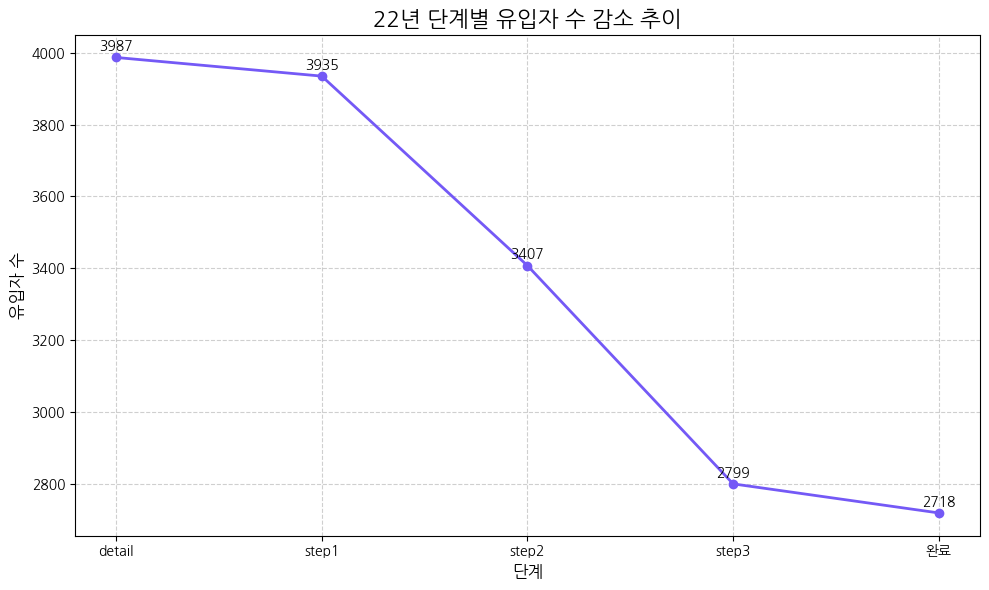

In [ ]:
# 단계 이름과 유입자 수 (너의 실제 값으로 바꿔줘)
stage_names = ["detail", "step1", "step2", "step3", "완료"]
counts = [log_2022_detail_numbers, log_2022_step_1_numbers, log_2022_step_2_numbers, log_2022_step_3_numbers, log_2022_done_numbers]

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(stage_names, counts, marker='o', linestyle='-', color='#7459f6', linewidth=2)
plt.title("22년 단계별 유입자 수 감소 추이", fontsize=16)
plt.xlabel("단계", fontsize=12)
plt.ylabel("유입자 수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 각 점에 유입자 수 표시
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## log_2023_done_df 만들기

In [ ]:
# 가입 관련 URL 방문 로그 추출
log_2023_acquisition_logs = log_2023_df[log_2023_df["cleaned_url"].isin(acquisition_urls)]

In [ ]:
# clean_url 만들기
log_2023_acquisition_logs["clean_url"] = log_2023_acquisition_logs["cleaned_url"].str.lower()

# 퍼널 단계 정의
funnel_stages = {
    "detail": ["detail"],
    "step1": ["signup/step1"],
    "step2": ["signup/step2"],
    "step3": ["signup/step3"]
}

# 퍼널 단계 부여 함수
def assign_funnel_stage(url):
    url = str(url).lower()
    for stage, keywords in funnel_stages.items():
        if any(k in url for k in keywords):
            return stage
    return "other"

# funnel_stage 컬럼 생성
log_2023_acquisition_logs["funnel_stage"] = log_2023_acquisition_logs["clean_url"].apply(assign_funnel_stage)

<ipython-input-19-48b5b844985e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_2023_acquisition_logs["clean_url"] = log_2023_acquisition_logs["cleaned_url"].str.lower()
<ipython-input-19-48b5b844985e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_2023_acquisition_logs["funnel_stage"] = log_2023_acquisition_logs["clean_url"].apply(assign_funnel_stage)


In [ ]:
log_2023_detail_stage = log_2023_acquisition_logs[log_2023_acquisition_logs["funnel_stage"] == "detail"]
log_2023_detail_members = log_2023_detail_stage["user_uuid"].unique()
log_2023_detail_numbers = log_2023_detail_stage["user_uuid"].nunique()

log_2023_detail_df = log_2023_acquisition_logs[log_2023_acquisition_logs['user_uuid'].isin(log_2023_detail_members)].reset_index(drop=True)

# detail -> step1
log_2023_step_1_stage = log_2023_detail_df[log_2023_detail_df["funnel_stage"] == "step1"]

log_2023_step_1_members = log_2023_step_1_stage["user_uuid"].unique()

log_2023_step_1_stage = log_2023_detail_df[log_2023_detail_df["funnel_stage"] == "step1"]
log_2023_step_1_members = log_2023_step_1_stage["user_uuid"].unique()
log_2023_step_1_numbers = log_2023_step_1_stage["user_uuid"].nunique()

log_2023_step_1_df = log_2023_detail_df[log_2023_detail_df['user_uuid'].isin(log_2023_step_1_members)].reset_index(drop=True)

# step1 -> step2
log_2023_step_2_stage = log_2023_step_1_df[log_2023_step_1_df["funnel_stage"] == "step2"]
log_2023_step_2_members = log_2023_step_2_stage["user_uuid"].unique()
log_2023_step_2_numbers = log_2023_step_2_stage["user_uuid"].nunique()

log_2023_step_2_df = log_2023_step_1_df[log_2023_step_1_df['user_uuid'].isin(log_2023_step_2_members)].reset_index(drop=True)

# step2 -> step3
log_2023_step_3_stage = log_2023_step_2_df[log_2023_step_2_df["funnel_stage"] == "step3"]
log_2023_step_3_members = log_2023_step_3_stage["user_uuid"].unique()
log_2023_step_3_numbers = log_2023_step_3_stage["user_uuid"].nunique()

log_2023_step_3_df = log_2023_step_2_df[log_2023_step_2_df['user_uuid'].isin(log_2023_step_3_members)].reset_index(drop=True)
log_2023_done_df = log_2023_step_3_df[log_2023_step_3_df["cleaned_url"] == "signup/step3/done"]
log_2023_done_numbers = log_2023_done_df["user_uuid"].nunique()

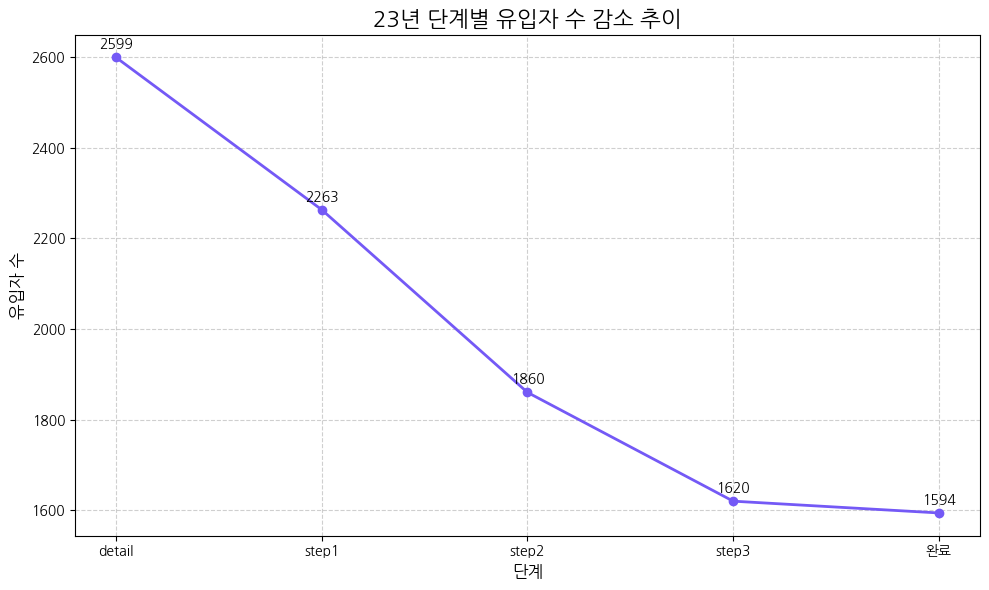

In [ ]:
# 단계 이름과 유입자 수 (너의 실제 값으로 바꿔줘)
stage_names = ["detail", "step1", "step2", "step3", "완료"]
counts = [log_2023_detail_numbers, log_2023_step_1_numbers, log_2023_step_2_numbers, log_2023_step_3_numbers, log_2023_done_numbers]

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(stage_names, counts, marker='o', linestyle='-', color='#7459f6', linewidth=2)
plt.title("23년 단계별 유입자 수 감소 추이", fontsize=16)
plt.xlabel("단계", fontsize=12)
plt.ylabel("유입자 수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 각 점에 유입자 수 표시
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 22 + 23 과 concat 22 23 유저 비교해보기

In [ ]:
concat_done_members = concat_done_df["user_uuid"].unique()
log_2022_done_members = log_2022_done_df["user_uuid"].unique()
log_2023_done_members = log_2023_done_df["user_uuid"].unique()

In [ ]:
concat_done_members

array(['000b55ad-5c86-438b-a5b0-9ea3a2917789',
       '0017a738-4fcc-441e-983b-a6033890a9db',
       '00605090-bd12-4978-884b-c74e093b40d0', ...,
       'ffe6aee0-85cc-45e2-aa5e-129751dff08e',
       'ffee959d-51e1-41d1-b662-1e55c7c379bf',
       'fff45252-3c40-4805-99e9-6b650c1fca80'], dtype=object)

In [ ]:
log_2022_done_members

array(['0017a738-4fcc-441e-983b-a6033890a9db',
       '007f87f4-adf8-45be-a6be-8f7121f1cbaf',
       '00bcd13a-391c-4745-8b7e-e24517e91c1d', ...,
       'ffe429f9-200e-472d-9d72-2742727c8ea8',
       'ffe6aee0-85cc-45e2-aa5e-129751dff08e',
       'fff45252-3c40-4805-99e9-6b650c1fca80'], dtype=object)

In [ ]:
log_2023_done_members

array(['000b55ad-5c86-438b-a5b0-9ea3a2917789',
       '00605090-bd12-4978-884b-c74e093b40d0',
       '006a406d-0e49-4e85-a171-e83ebcbb109a', ...,
       'ff2d1be1-2629-401e-ba35-0031fa6c8c5a',
       'ff75a922-f16b-41b2-9ca7-954a61ac08f2',
       'ffee959d-51e1-41d1-b662-1e55c7c379bf'], dtype=object)

In [ ]:
# 1. 두 배열을 합치기
combined = np.concatenate([log_2022_done_members, log_2023_done_members])

# 2. 중복 제거 없이 합친 경우의 데이터 개수
print("합치기만 했을 때 데이터 개수:", combined.shape[0])
print()

# 3. 합친 후 고유 데이터 개수
combined_unique = np.unique(combined)
print("합친 후 고유 데이터 개수:", combined_unique.shape[0])
print()

# 4. concat_done_members와 비교
print("concat_done_members 데이터 개수:", concat_done_members.shape[0])
print()

# 5. 중복된 값 찾기
# 두 리스트에서 모두 존재하는 ID (중복 ID)
duplicated_ids = np.intersect1d(log_2022_done_members, log_2023_done_members)

print("중복된 ID 수:", duplicated_ids.shape[0])
print()
print("중복된 ID 목록:", duplicated_ids)

합치기만 했을 때 데이터 개수: 4312

합친 후 고유 데이터 개수: 4270

concat_done_members 데이터 개수: 4273

중복된 ID 수: 42

중복된 ID 목록: ['00e15587-dbaf-49d8-a4c5-f08034e10802'
 '11dd02ad-e7ff-48d3-8c96-6db298de9f09'
 '136f61d7-3302-4e68-825b-eb4e9a2a9e49'
 '2570604d-ddc6-49e2-b4fe-0a7b62bff8fc'
 '2d16d2bc-3281-4d5c-b057-3d3d67c9d01f'
 '2f52caca-3313-4ab2-a338-9e42cb4adae7'
 '33f9b926-e8a5-4844-b101-99e5072a3cc8'
 '42af347c-795d-4839-b84a-432199dc383a'
 '44a60103-ca39-4192-9728-7ba9f0f55e8c'
 '5942450d-7f58-4bf8-8def-a159d11c598b'
 '5a339b0e-5dc3-420e-8ba8-c8aead23c801'
 '674c7554-934a-4ec5-8074-e12e3af7504a'
 '7807856f-f3e6-4d4e-a801-94adbc4f6735'
 '7b120cc7-187e-4869-9817-fcdbde0e892d'
 '820b97bf-abdc-4e1e-b875-0b08537b8e18'
 '82d5f77c-fbb7-4982-94a8-d6fe005cb203'
 '856c5185-158f-44ee-987b-eae4ad5e1a7d'
 '8615a614-1c21-444d-85f8-2e5b0a4b6da6'
 '8ae56c12-dcbc-4646-afba-ba22d78738e5'
 'a0750dec-e64b-4d8a-99fd-abfeadae1493'
 'a6af4a36-ae6a-4a2d-8e73-c2a3ddaad37d'
 'aa3f7be1-42f6-470f-8e61-3b881e951ae0'
 'aa6c3e99-542a

- 22년도 회원가입 완료 수 + 23년도 회원가입 완료 수 = 4312

- (22년도 회원가입 완료 유저 + 23년도 회원가입 완료 유저)의 고유값 = 4270
    - 중복된 ID가 42개가 있다
        - unique()를 사용하여 추출 (고유값만 추출), 중복값을 제거하지는 않았다
            - 각 step별 중복값이 데이터프레임 안에는 남아있다.

- concat 회원가입 완료 수 4273
    - 고유값보다 3개 늘어남 -> 3명은 22~23에 거쳐서 회원가입 완료 (22년, 23년 각각 보았을때는 나타나지 않는 유저)

In [ ]:
example_user_1 = concat_done_df[concat_done_df["user_uuid"] == "ab5f99dd-2898-46bc-be60-6dee637eaac6"]
example_user_1

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
31325,9749890,ab5f99dd-2898-46bc-be60-6dee637eaac6,signup/step3/done,2022-03-06 12:10:04.042432,2022-03-06,200,GET,signup/step3/done,signup/step3/done,step3
31332,3949031,ab5f99dd-2898-46bc-be60-6dee637eaac6,signup/step3/done,2023-06-19 04:29:27.515606,2023-06-19,200,GET,signup/step3/done,signup/step3/done,step3


# ???: 뭐라고 하는건 아니예요

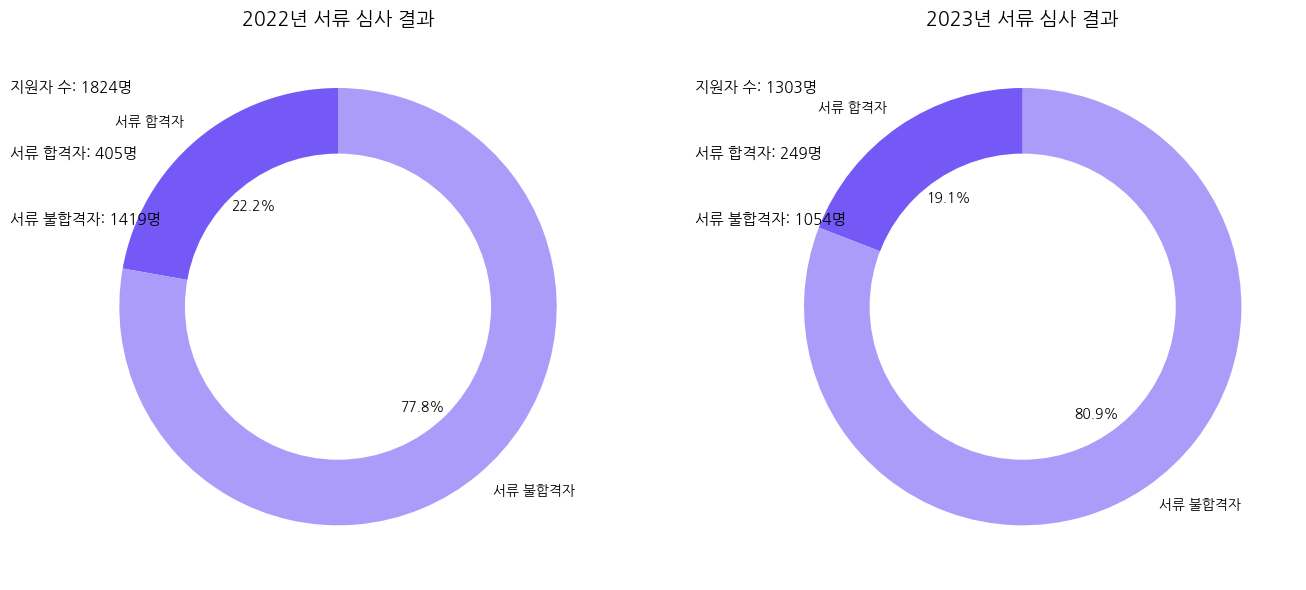

In [ ]:
# 데이터
years = ['2022', '2023']
supporters = [1824, 1303]
pass_docs = [405, 249]
fail_docs = [1419, 1054]

# 색상
colors = ['#7459f6', '#ac9cfa']  # 초록, 빨강

# 도넛형 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, ax in enumerate(axes):
    # 데이터 준비
    year = years[i]
    total = supporters[i]
    pass_count = pass_docs[i]
    fail_count = fail_docs[i]

    percentages = [pass_count / total * 100, fail_count / total * 100]
    labels = ['서류 합격자', '서류 불합격자']

    # 파이 차트 (도넛형)
    wedges, texts, autotexts = ax.pie(
        percentages,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops=dict(width=0.4)
    )

    # 가운데 원 추가
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)

    # 제목
    ax.set_title(f'{year}년 서류 심사 결과', fontsize=14)

    # 텍스트 추가 (좌측 정렬)
    ax.text(-1.5, 1.0, f'지원자 수: {total}명', fontsize=11, verticalalignment='center')
    ax.text(-1.5, 0.7, f'서류 합격자: {pass_count}명', fontsize=11, verticalalignment='center')
    ax.text(-1.5, 0.4, f'서류 불합격자: {fail_count}명', fontsize=11, verticalalignment='center')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

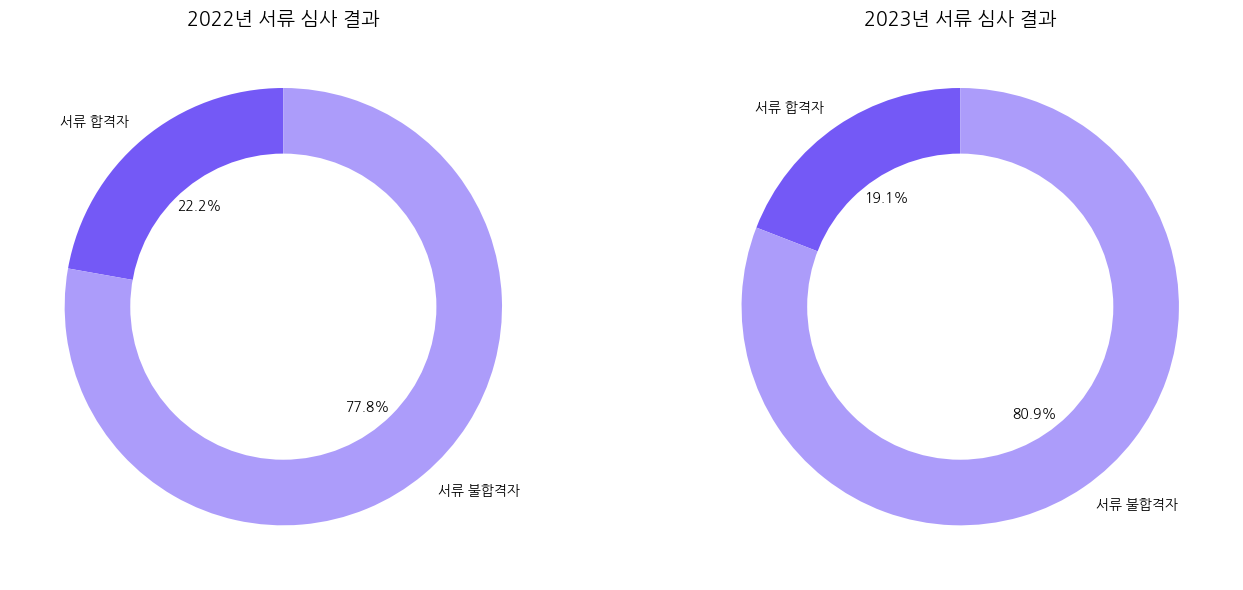

In [52]:
# 데이터
years = ['2022', '2023']
supporters = [1824, 1303]
pass_docs = [405, 249]
fail_docs = [1419, 1054]

# 색상
colors = ['#7459f6', '#ac9cfa']  # 초록, 빨강

# 도넛형 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, ax in enumerate(axes):
    # 데이터 준비
    year = years[i]
    total = supporters[i]
    pass_count = pass_docs[i]
    fail_count = fail_docs[i]

    percentages = [pass_count / total * 100, fail_count / total * 100]
    labels = ['서류 합격자', '서류 불합격자']

    # 파이 차트 (도넛형)
    wedges, texts, autotexts = ax.pie(
        percentages,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops=dict(width=0.4)
    )

    # 가운데 원 추가
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)

    # 제목
    ax.set_title(f'{year}년 서류 심사 결과', fontsize=14)

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

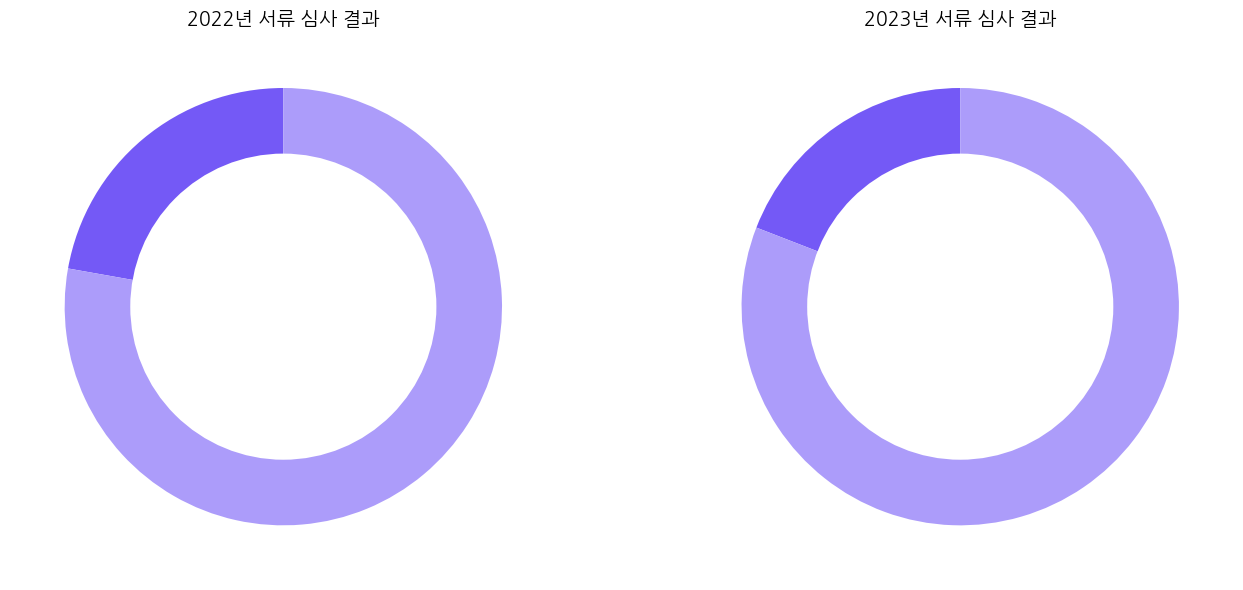

In [53]:
# 데이터
years = ['2022', '2023']
supporters = [1824, 1303]
pass_docs = [405, 249]
fail_docs = [1419, 1054]

# 색상
colors = ['#7459f6', '#ac9cfa']

# 도넛형 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, ax in enumerate(axes):
    # 데이터 준비
    year = years[i]
    total = supporters[i]
    pass_count = pass_docs[i]
    fail_count = fail_docs[i]

    percentages = [pass_count / total * 100, fail_count / total * 100]

    # 파이 차트 (도넛형) - labels, autopct 제거
    wedges, texts = ax.pie(
        percentages,
        startangle=90,
        colors=colors,
        wedgeprops=dict(width=0.4)
    )

    # 가운데 원 추가
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)

    # 제목
    ax.set_title(f'{year}년 서류 심사 결과', fontsize=14)

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()